In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

class SOM:
    def __init__(self, x, y, input_dim, sigma=1.0, learning_rate=0.5, random_seed=None):
        self.x = x
        self.y = y
        self.input_dim = input_dim
        self.sigma = sigma
        self.lr = learning_rate
        self.rng = np.random.RandomState(random_seed)
        self.weights = self.rng.rand(x, y, input_dim)
        self._init_location_grid()

    def _init_location_grid(self):
        self.locations = np.array([[(i, j) for j in range(self.y)] for i in range(self.x)])

    def _neighborhood(self, bmu_idx, sigma):
        dist_sq = np.sum((self.locations - bmu_idx) ** 2, axis=2)
        return np.exp(-dist_sq / (2 * (sigma ** 2)))

    def winner(self, v):
        diffs = self.weights - v.reshape(1, 1, -1)
        dist_sq = np.sum(diffs ** 2, axis=2)
        idx = np.unravel_index(np.argmin(dist_sq, axis=None), (self.x, self.y))
        dist = np.min(dist_sq)
        return idx, dist

    def train(self, data, num_iterations):
        time_constant = num_iterations / np.log(max(self.sigma, 1e-8))
        for t in range(num_iterations):
            idx = self.rng.randint(0, data.shape[0])
            v = data[idx]
            (bi, bj), _ = self.winner(v)
            lr_t = self.lr * np.exp(-t / num_iterations)
            sigma_t = self.sigma * np.exp(-t / time_constant)
            h = self._neighborhood((bi, bj), sigma_t)[:, :, np.newaxis]
            self.weights += lr_t * h * (v - self.weights)

    def distance_map(self):
        umatrix = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                w = self.weights[i, j]
                neigh = []
                for di, dj in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < self.x and 0 <= nj < self.y:
                        neigh.append(np.linalg.norm(w - self.weights[ni, nj]))
                umatrix[i, j] = np.mean(neigh) if neigh else 0
        return umatrix

    def map_vects(self, data):
        mapped = np.zeros((data.shape[0], 2), dtype=int)
        dists = np.zeros(data.shape[0])
        for i, v in enumerate(data):
            (bi, bj), dist = self.winner(v)
            mapped[i] = [bi, bj]
            dists[i] = dist
        return mapped, dists


In [ ]:
def load_and_prepare(path):
    df = pd.read_csv(path)
    # Drop customerID column (case insensitive)
    drop_cols = [col for col in df.columns if col.lower() in ['customerid', 'customer_id']]
    df = df.drop(columns=drop_cols, errors='ignore')

    # Extract class label if exists (for marking actual frauds)
    class_col_candidates = [c for c in df.columns if c.lower() == 'class']
    y = None
    if class_col_candidates:
        y = df[class_col_candidates[0]].values
        df = df.drop(columns=[class_col_candidates[0]])

    df = df.dropna(axis=0)  # Drop missing data rows

    scaler = MinMaxScaler()
    X = scaler.fit_transform(df.values.astype(float))

    return X, y, df.columns.tolist()


def quantization_error(som, data):
    _, dists = som.map_vects(data)
    return np.mean(dists)


def hyperparameter_tune(X, grid):
    best = None
    best_err = np.inf
    for params in ParameterGrid(grid):
        som = SOM(params['x'], params['y'], X.shape[1], sigma=params['sigma'], learning_rate=params['lr'])
        som.train(X, params['epochs'])
        err = quantization_error(som, X)
        if err < best_err:
            best_err = err
            best = (params, som, err)
    return best

In [ ]:
def detect_anomalies(som, X, method='threshold', thresh_coef=1.5, top_n=None):
    mapped, dists = som.map_vects(X)
    if method == 'threshold':
        mean, std = dists.mean(), dists.std()
        threshold = mean + thresh_coef * std
        idx = np.where(dists > threshold)[0]
    else:
        idx = np.argsort(dists)[-top_n:] if top_n else np.array([], dtype=int)
    return idx, mapped, dists


def plot_results(som, umatrix, mapped, y=None, anomalies_idx=None, savepath=None):
    import matplotlib.patches as patches

    plt.figure(figsize=(10, 8))
    plt.title('SOM U-Matrix with Markers')
    plt.imshow(umatrix.T, origin='lower')
    plt.colorbar(label='U-Matrix Distance')
    ax = plt.gca()

    for i in range(mapped.shape[0]):
        x, yv = mapped[i]
        if anomalies_idx is not None and i in anomalies_idx:
            ax.plot(x, yv, marker='o', markeredgecolor='k', markerfacecolor='none', markersize=10)
        elif y is not None and y[i] == 1:
            ax.plot(x, yv, marker='x', markersize=8, color='r')
        else:
            ax.plot(x, yv, marker='.', markersize=5, color='b')

    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    plt.show()



Loading and preparing data...
Data shape: (690, 14)
Starting hyperparameter tuning...


/tmp/ipython-input-1202888118.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  time_constant = num_iterations / np.log(max(self.sigma, 1e-8))


Best params: {'epochs': 200, 'lr': 0.5, 'sigma': 1.5, 'x': 9, 'y': 9}
Quantization error: 0.3565
Generating U-Matrix...
Detecting anomalies...
Number of anomalies detected: 65
Plotting results...


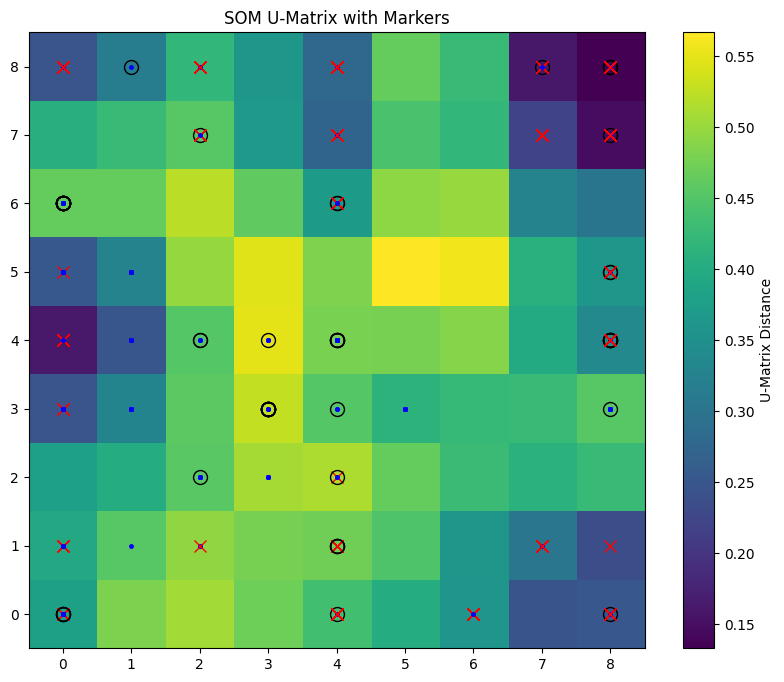

Detected anomalies saved to detected_anomalies.csv


In [ ]:
if __name__ == '__main__':
    # Change this to the path where you downloaded the dataset CSV
    path = 'Credit_Card_Applications.csv'

    print("Loading and preparing data...")
    X, y, feature_names = load_and_prepare(path)
    print(f"Data shape: {X.shape}")

    # Hyperparameter grid
    grid = {
        'x': [7, 9],
        'y': [7, 9],
        'sigma': [1.0, 1.5],
        'lr': [0.5, 0.3],
        'epochs': [100, 200]
    }

    print("Starting hyperparameter tuning...")
    best_params, best_som, best_err = hyperparameter_tune(X, grid)
    print(f"Best params: {best_params}")
    print(f"Quantization error: {best_err:.4f}")

    print("Generating U-Matrix...")
    umatrix = best_som.distance_map()

    print("Detecting anomalies...")
    anomalies_idx, mapped, dists = detect_anomalies(best_som, X, method='threshold', thresh_coef=1.5)
    print(f"Number of anomalies detected: {len(anomalies_idx)}")

    print("Plotting results...")
    plot_results(best_som, umatrix, mapped, y, anomalies_idx, savepath='som_anomaly_detection.png')

    # Save anomalies to CSV
    detected = pd.DataFrame({'index': anomalies_idx, 'distance': dists[anomalies_idx]})
    detected_sorted = detected.sort_values(by='distance', ascending=False)
    detected_sorted.to_csv('detected_anomalies.csv', index=False)
    print("Detected anomalies saved to detected_anomalies.csv")